In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")

In [2]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
data_location = '../../../neuralprophet-data/datasets/'

sf_pv_df = pd.read_csv(data_location +  'energy/SF_PV.csv')

## Renewable Energy: Forecasting hourly solar irradiance
The training will occur on 90% of the data, reserving the last 10% for evaluation.

### Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

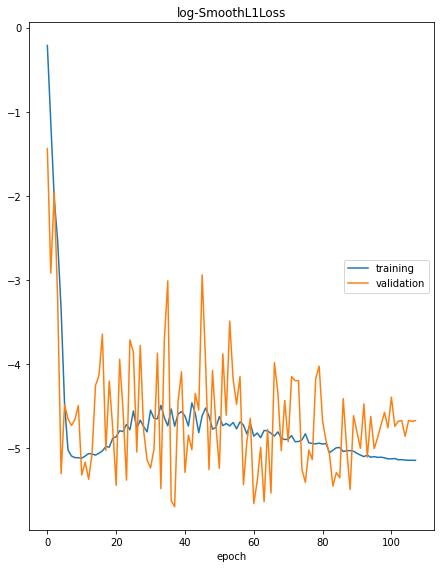

Epoch[108/108]: 100%|██████████████████████| 108/108 [00:31<00:00,  3.48it/s, SmoothL1Loss=0.00585, MAE=52.2, MSE=9.09e+3, RegLoss=0, MAE_val=61.4, MSE_val=1.46e+4, SmoothL1Loss_val=0.00937]


In [37]:
m = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=8,
    n_changepoints=5,
    # changepoints_range=0.85,
    seasonality_mode='multiplicative',
    learning_rate=0.1,
)
sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(sf_pv_df_train, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [38]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.005845,52.183002,9094.696605,0.0,0.009373,61.414753,14583.020508


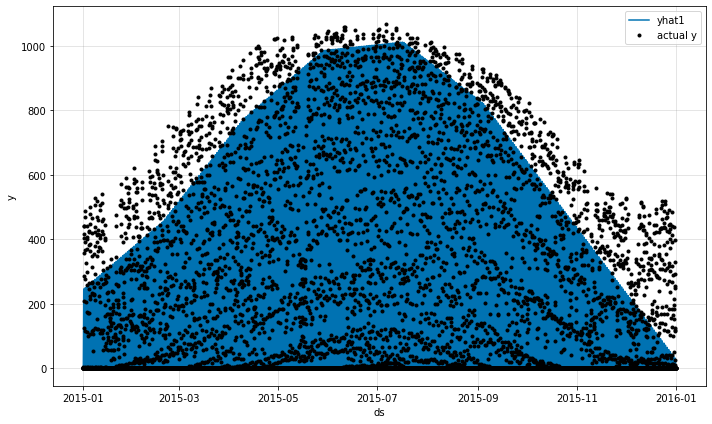

In [39]:
forecast = m.predict(sf_pv_df)
fig = m.plot(forecast)

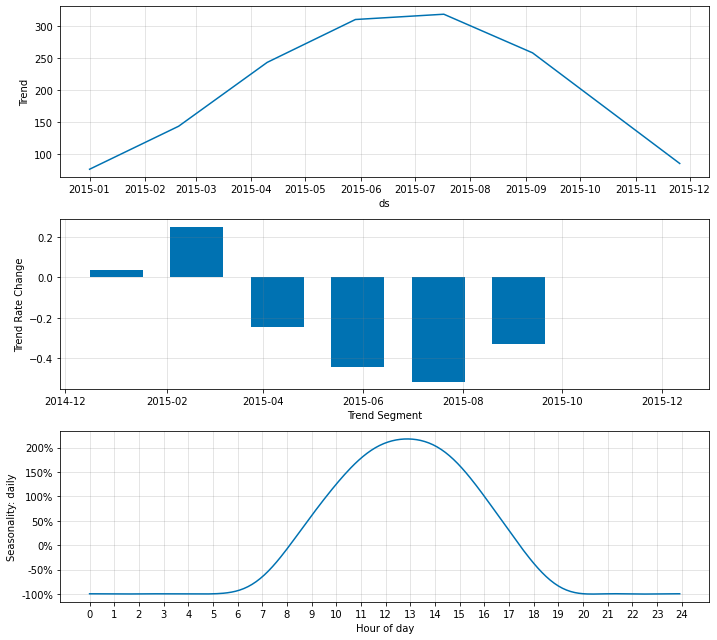

In [40]:
fig_param = m.plot_parameters()


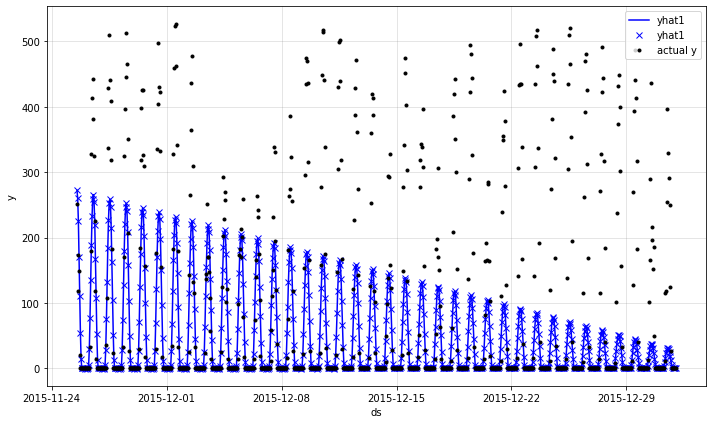

In [41]:
forecast = m.predict(sf_pv_df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

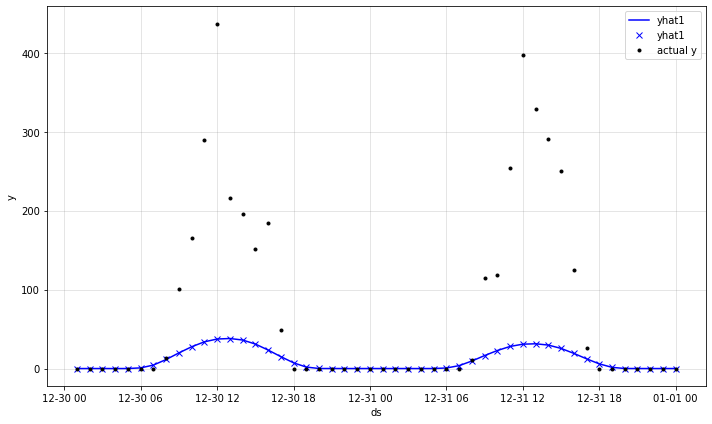

In [42]:
fig_prediction = m.plot(forecast[-48:])


### 1-step ahead forecast with Auto-Regresseion
In this second section, we will train a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). We can train this forecaster considering the privious 24 steps and disabling trend and seasonality.

The paramters that we can modify are for the AR sparsity and the neural network architecture

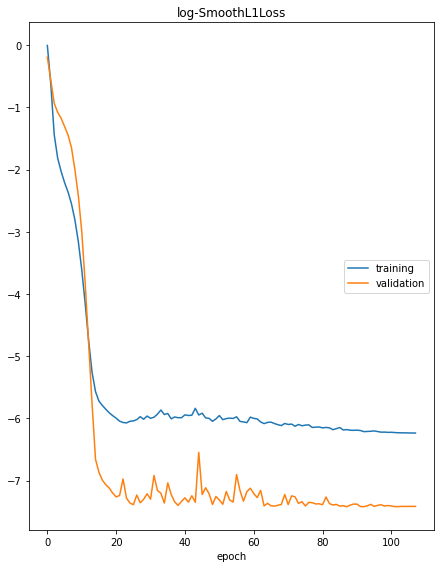

Epoch[108/108]: 100%|█████████████████████████| 108/108 [00:21<00:00,  4.95it/s, SmoothL1Loss=0.00196, MAE=30.2, MSE=3.05e+3, RegLoss=0, MAE_val=18.3, MSE_val=936, SmoothL1Loss_val=0.000602]


In [9]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    # ar_sparsity=0.8,
    learning_rate=0.01,
)

sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(sf_pv_df_train, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [10]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.001957,30.248701,3045.145612,0.0,0.000602,18.303909,936.382629


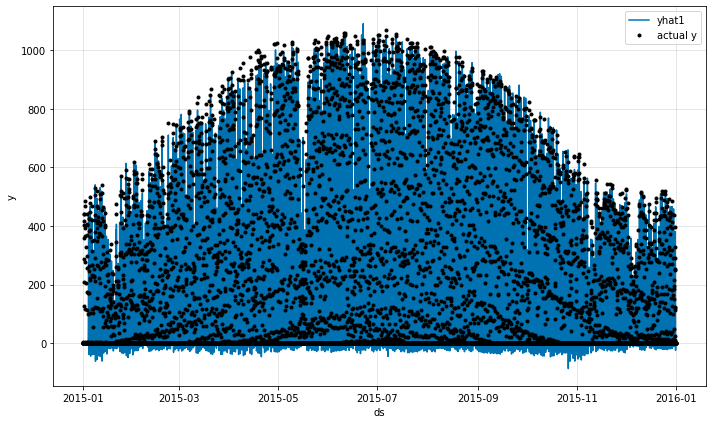

In [11]:
forecast = m.predict(sf_pv_df)
fig = m.plot(forecast)

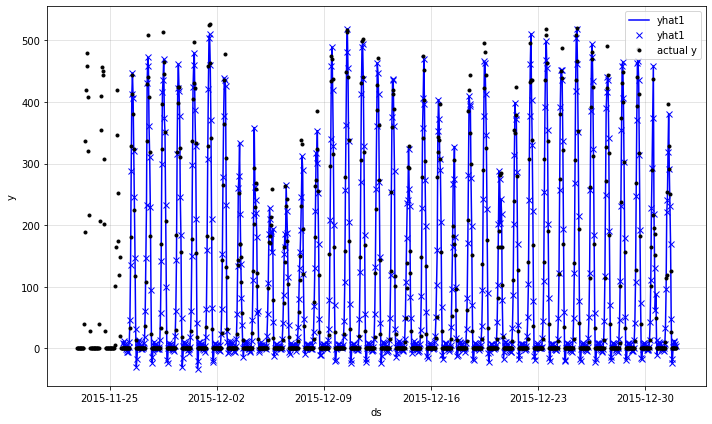

In [12]:
forecast = m.predict(sf_pv_df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

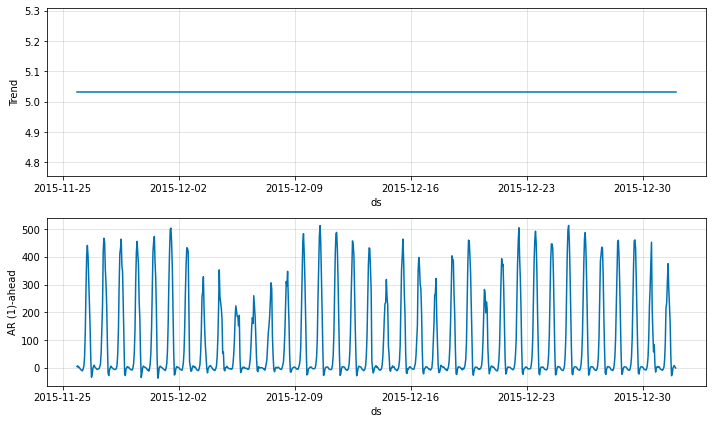

In [13]:
fig_comp = m.plot_components(forecast)

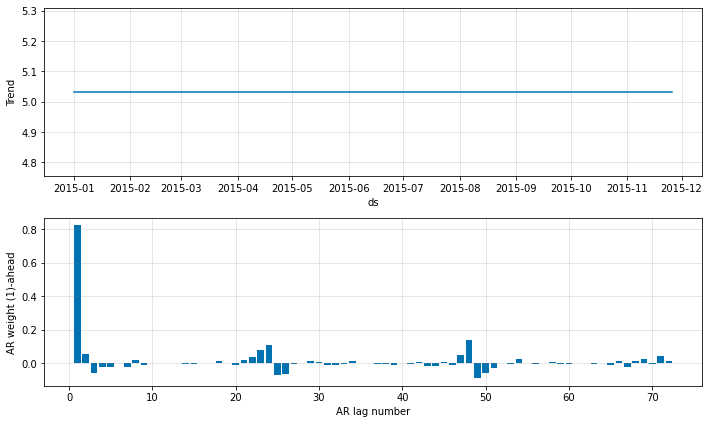

In [14]:
fig_param = m.plot_parameters()


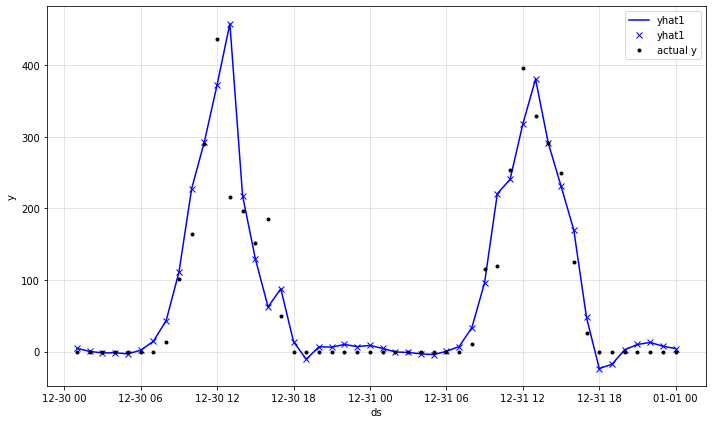

In [15]:
fig_prediction = m.plot(forecast[-48:])


#### Sparsifying the AR coefficients
By setting an `ar_sparsity < 1` we can reduce the number of non-zero AR coefficients. 

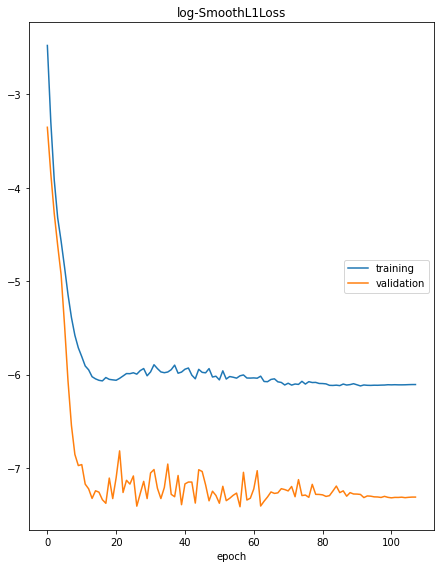

Epoch[108/108]: 100%|███████████████| 108/108 [00:23<00:00,  4.54it/s, SmoothL1Loss=0.00223, MAE=32.6, MSE=3.47e+3, RegLoss=0.00183, MAE_val=18.2, MSE_val=1.04e+3, SmoothL1Loss_val=0.000668]


In [16]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_sparsity=0.7,
    learning_rate=0.01,
)

sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(sf_pv_df_train, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [17]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.00223,32.564169,3468.782573,0.001835,0.000668,18.240438,1039.28833


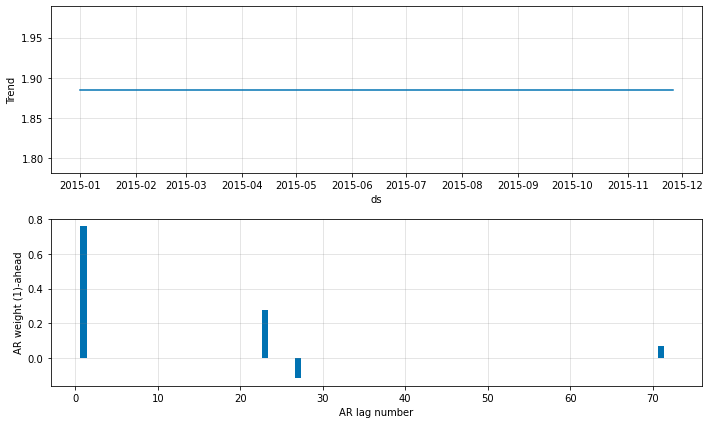

In [18]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

### 1 step ahead forecast with AR-Net
There is something to consider here, if we consider a neural network with at least one hidden layer. For a high enough learning rate (probably > 0.1), the gradient seems to vanish and forces the AR net output to 0.  

From below, we can see that the forecast output has a strange behavior. it looks like the output is exactly the sum of the weekly, daily seasonlality with trend. With no noise and changes at all.

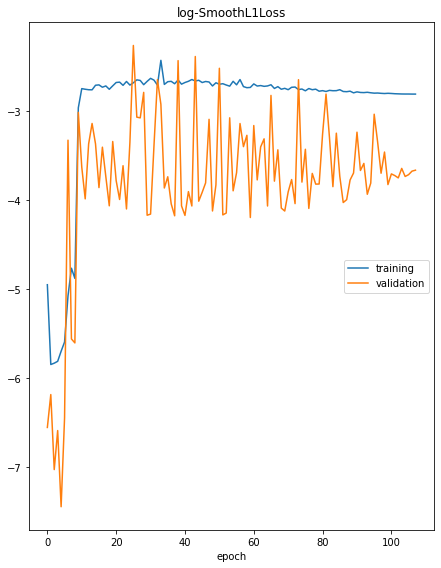

Epoch[108/108]: 100%|████████████████████████████| 108/108 [00:37<00:00,  2.89it/s, SmoothL1Loss=0.06, MAE=257, MSE=9.34e+4, RegLoss=0, MAE_val=189, MSE_val=3.97e+4, SmoothL1Loss_val=0.0255]


In [19]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=1.0,
)

sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(sf_pv_df_train, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [20]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.060033,257.231591,93401.827134,0.0,0.025532,188.706116,39723.816406


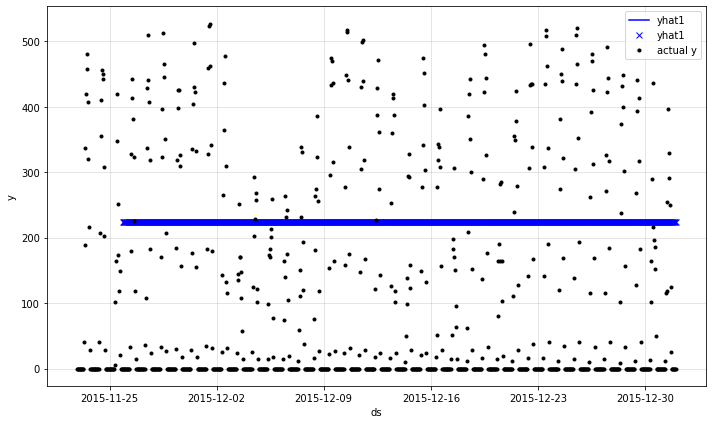

In [21]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
forecast = m.predict(sf_pv_df_test)
fig = m.plot(forecast)

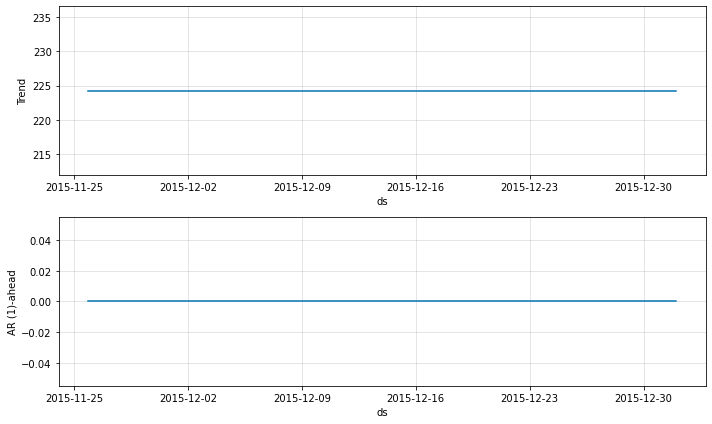

In [22]:
fig_comp = m.plot_components(forecast)

#### Learning Rate matters when training a Neural Network.
An easy fix is to set the learning rate at a low enough value, likely around 0.01 to 0.001.

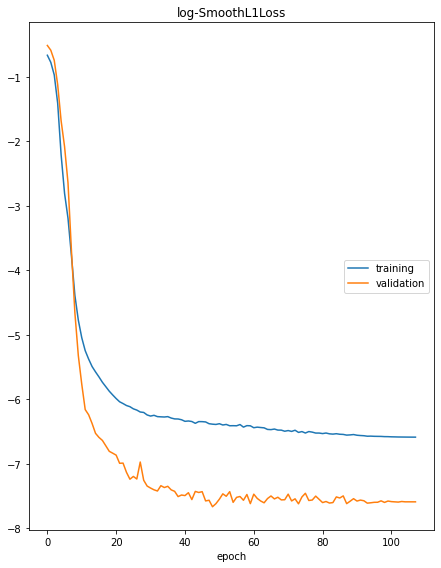

Epoch[108/108]: 100%|█████████████████████████| 108/108 [00:35<00:00,  3.03it/s, SmoothL1Loss=0.00138, MAE=22.3, MSE=2.15e+3, RegLoss=0, MAE_val=14.2, MSE_val=788, SmoothL1Loss_val=0.000507]


In [23]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.001,
)

sf_pv_df_train, sf_pv_df_test = m.split_df(sf_pv_df, freq='H', valid_p = 0.10)

metrics = m.fit(sf_pv_df_train, freq='H', validation_df=sf_pv_df_test, plot_live_loss=True)

In [24]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.001381,22.28955,2148.666349,0.0,0.000507,14.183768,788.437256


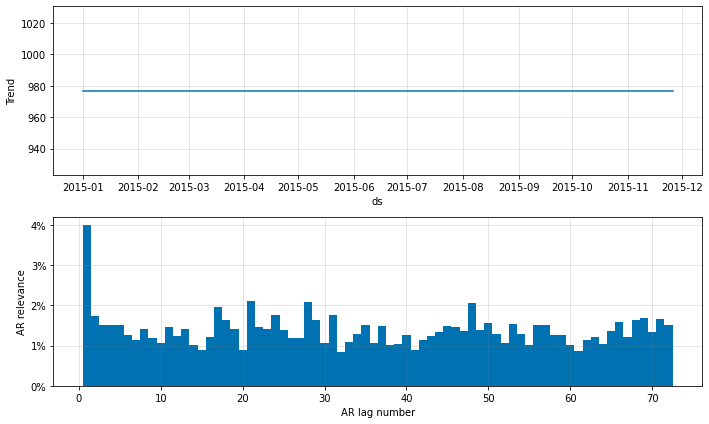

In [25]:
fig = m.plot_parameters()

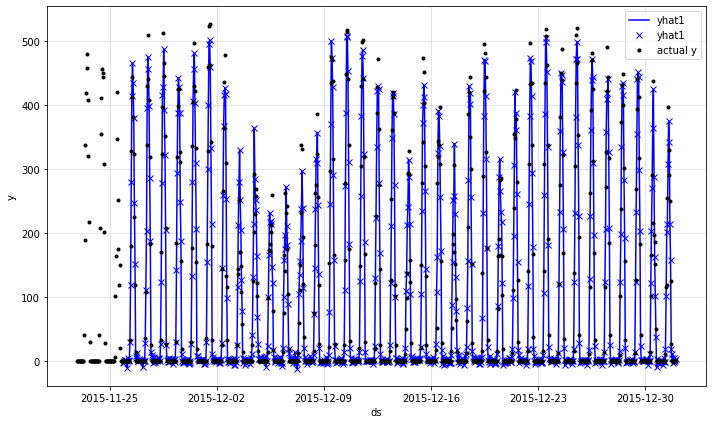

In [26]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
forecast = m.predict(sf_pv_df_test)
fig = m.plot(forecast)

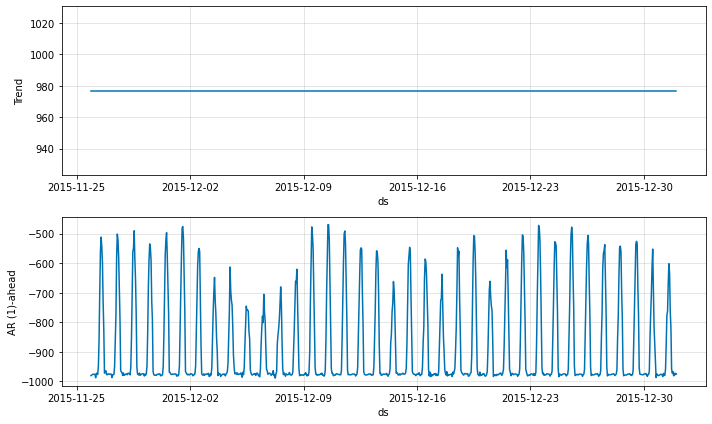

In [27]:
fig_comp = m.plot_components(forecast)

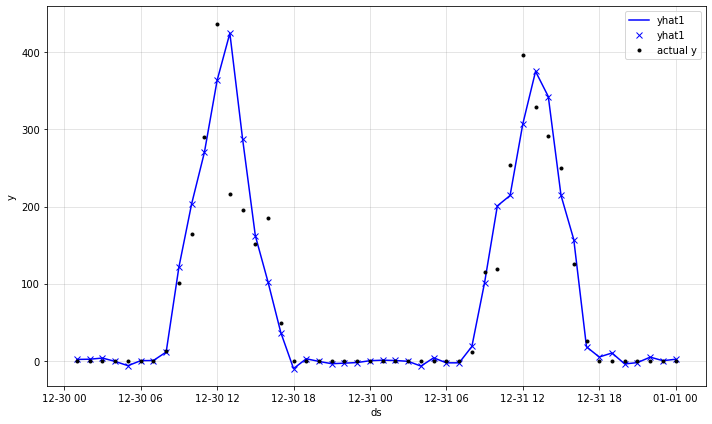

In [28]:
fig_prediction = m.plot(forecast[-48:])